In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import json
import cv2
import urllib

In [2]:
def read_csv(title):
    return pd.read_csv(title, sep=',', encoding='cp1252', engine='python')

def transform_df(df):
    del df['Unnamed: 0']
    df['comments_disabled'] = df['comments_disabled'].transform(lambda x: 0 if x=='False' else 1)
    df['ratings_disabled'] = df['ratings_disabled'].transform(lambda x: 0 if x=='False' else 1)
    return df

def get_category(df, file_name):
    categories_dict = {}
    with open(file_name) as file:
        cats = json.load(file)
        for x in cats['items']:
            categories_dict[x['id']] = x['snippet']['title']

    df['category_name'] = df['categoryId'].transform(lambda x: "Unknown" if x=='False' or not x or pd.isna(x) or str(int(float(x))) not in categories_dict else categories_dict[str(int(float(x)))])
    return df

def symbolic_transformer(df, name):
    return df['title'].transform(lambda x: len([y for y in x if y==name]) if x else 0)

def transform_df_symbols_and_title_nuissances(df):
    df['title_length'] = df['title'].transform(lambda x: None if x is None else len(x))
    df['description_length'] = df['description'].transform(lambda x: 0 if not x else len(str(x)))
    df['nr_tags'] = df['tags'].transform(lambda x: 0 if x is None or x=='[None]' else len(x.split('|')))
    df['link_amount'] = df['description'].transform(lambda x: 0 if not x else str(x).count('://'))
    
    df['interpunction_title'] = df['title'].transform(lambda x: len([y for y in x if y in [',', ';', '`', "'", '"', '.', '!', '?', ':']]) if x else 0)
    df['interpunction_exclamation'] = symbolic_transformer(df, '!')
    df['interpunction_question'] = symbolic_transformer(df, '?')
    df['interpunction_dot'] = symbolic_transformer(df, '.')
    df['interpunction_comma'] = symbolic_transformer(df, ',')
    
    df['screams'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90]) if x else 0)
    df['screams_to_normal_proportion'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90])/len(x) if x else 0)
    return df

def transform_dates(df):
    day_const = (3600*24)
    df['publishedAt_modern'] = df['publishedAt'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    df['trending_date_modern'] = df['trending_date'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    
    df['weekday_published'] = df['publishedAt_modern'].transform(lambda x: x.weekday())
    df['time_diff'] = (df['trending_date_modern']-df['publishedAt_modern']).transform(lambda x:x.total_seconds()/(day_const))
    return df

In [3]:
US95 = read_csv('USdata95.csv')
GB95 = read_csv('GBdata95.csv')

primal_gb = [GB95]
primal_us = [US95]
primal_gb = [get_category(x, 'GB_category_id.json') for x in primal_gb]
primal_us = [get_category(x, 'US_category_id.json') for x in primal_us]

elements = [*primal_gb]
elements.extend(primal_us)
elements = [transform_df(x) for x in elements]


elements = [transform_df_symbols_and_title_nuissances(x) for x in elements]
elements = [transform_dates(x) for x in elements]
all_movies = pd.concat(elements)
post_movies = all_movies.copy()
neo_movies = post_movies.sort_values(by='trending_date_modern').drop_duplicates(subset=['video_id'])

In [ ]:
amount = 100
for i, x in enumerate(neo_movies['thumbnail_link'][:amount]:
    try:
        urllib.request.urlretrieve(x, f'./images/file_{i}.jpg')
    except:
        print(f'Unable to show image nr {i}')
        pass

In [49]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

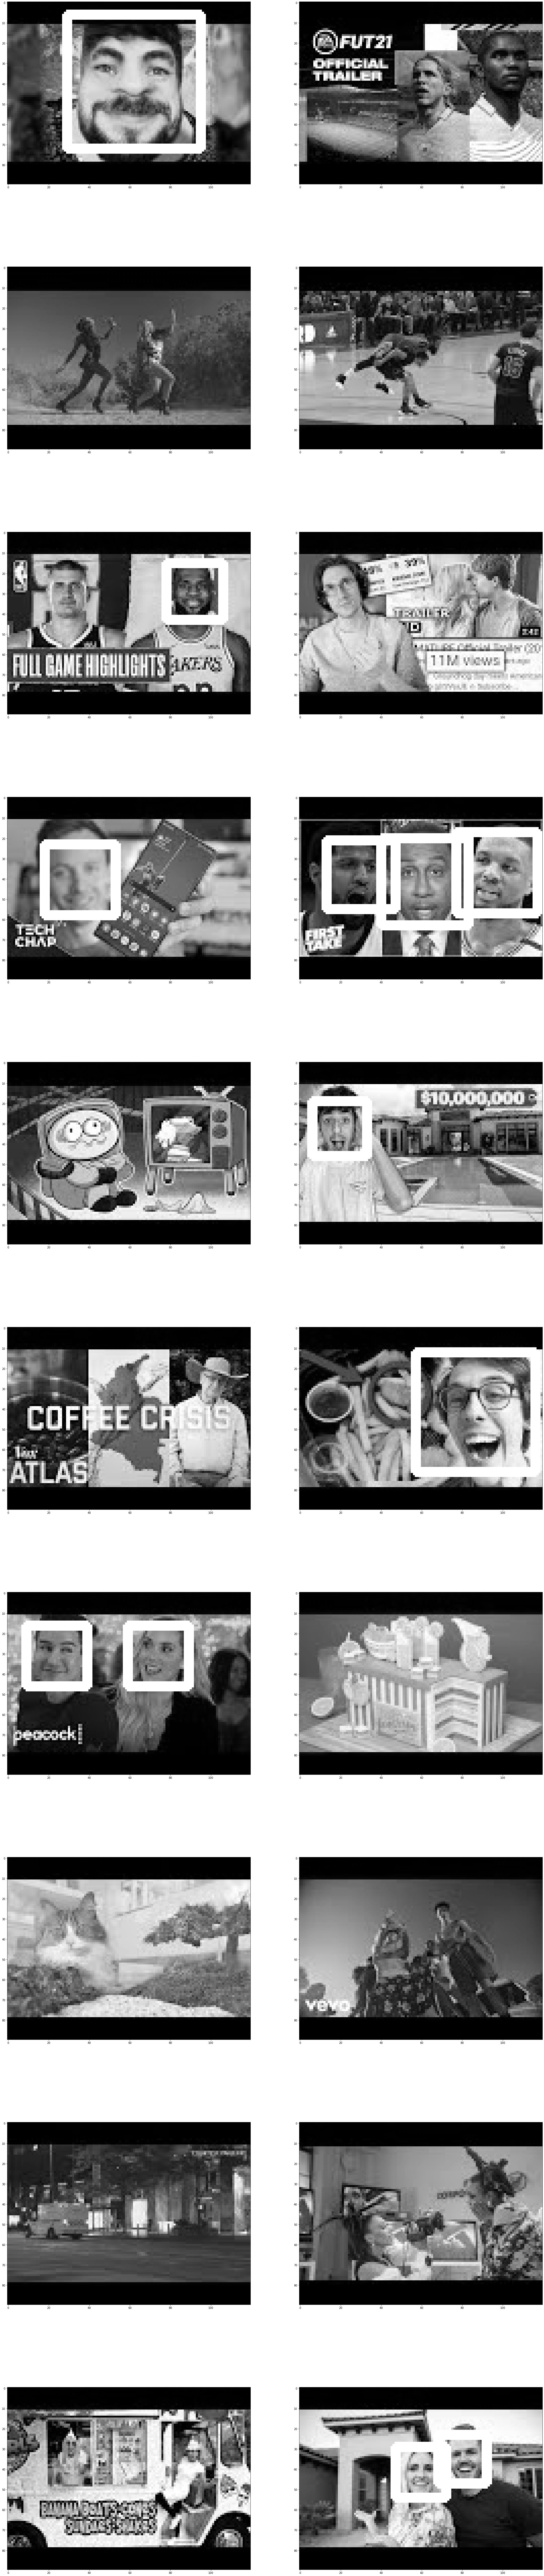

In [56]:
x_size, y_size=2, 10
fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

for i in range(y_size*x_size):
    img = cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=2,
        flags=cv2.CASCADE_SCALE_IMAGE
        )# For each face
    for (x, y, w, h) in faces: 
        # Draw rectangle around the face
        cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)
    
    ax[i//x_size][i%x_size].imshow(gray, cmap="gray")

In [75]:
images = [cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR) for i in range(amount) if i!=95]

In [76]:
amount_faces=[]
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=2,
        flags=cv2.CASCADE_SCALE_IMAGE
        )
    amount_faces.append(len(faces))
    
print(amount_faces)

[1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 3, 0]


In [93]:
mx_af = max(amount_faces)
count_amount_faces = [0]*(mx_af+1)
for x in amount_faces:
    count_amount_faces[x] += 1

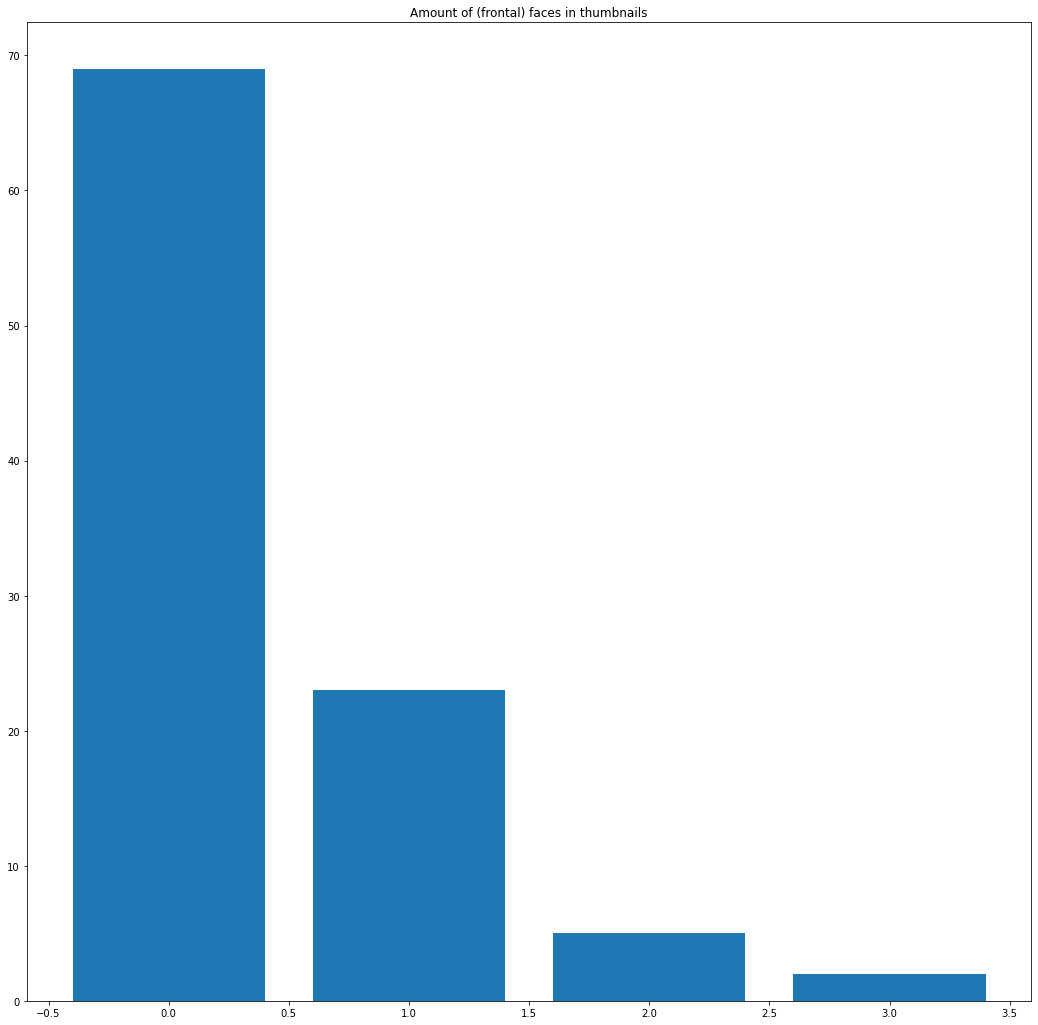

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(18,18))
ax.bar(list(range(mx_af+1)), count_amount_faces)
ax.set_title('Amount of (frontal) faces in thumbnails')
plt.show()

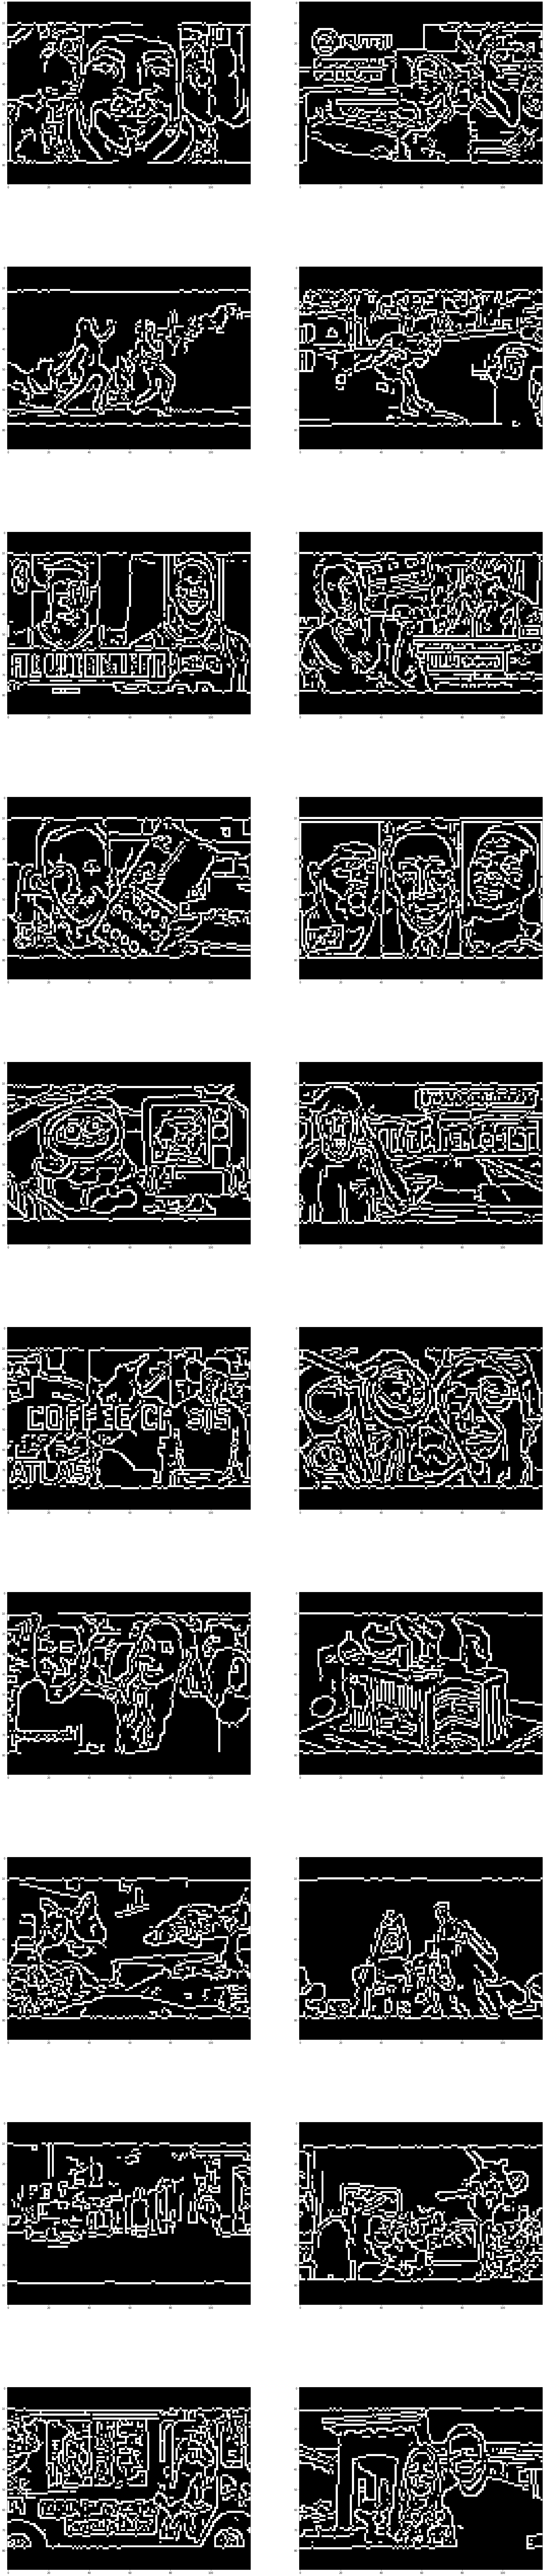

In [111]:
x_size, y_size=2, 10
fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

for i in range(y_size*x_size):
    img = cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)    
    img_edge = cv2.Canny(img,100,200)
    ax[i//x_size][i%x_size].imshow(img_edge, cmap="gray")

In [124]:
amount_action = []
for img in images:
    img_edge = cv2.Canny(img,100,200)
    summa = sum([sum(x) for x in img_edge])//255
    amount_action.append(summa/(img_edge.shape[0]*img_edge.shape[1]))

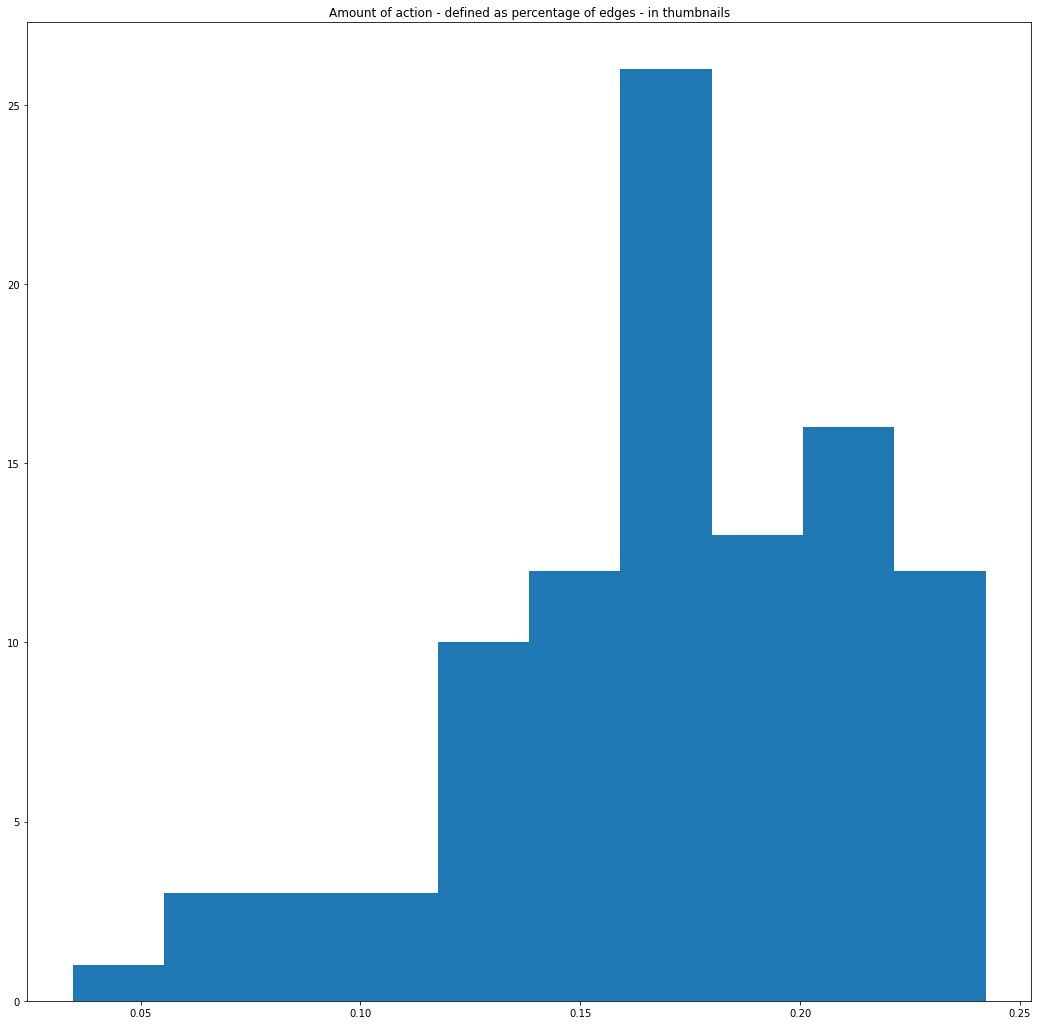

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(18,18))
ax.hist(amount_action)
ax.set_title('Amount of action - defined as percentage of edges - in thumbnails')
plt.show()

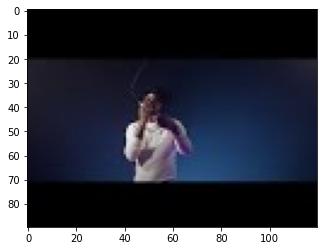

In [134]:
mn = min(amount_action)

min_img = [i for i,x in enumerate(amount_action) if x==mn][0]
plt.imshow(images[min_img][...,::-1])
plt.show()

In [39]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [41]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

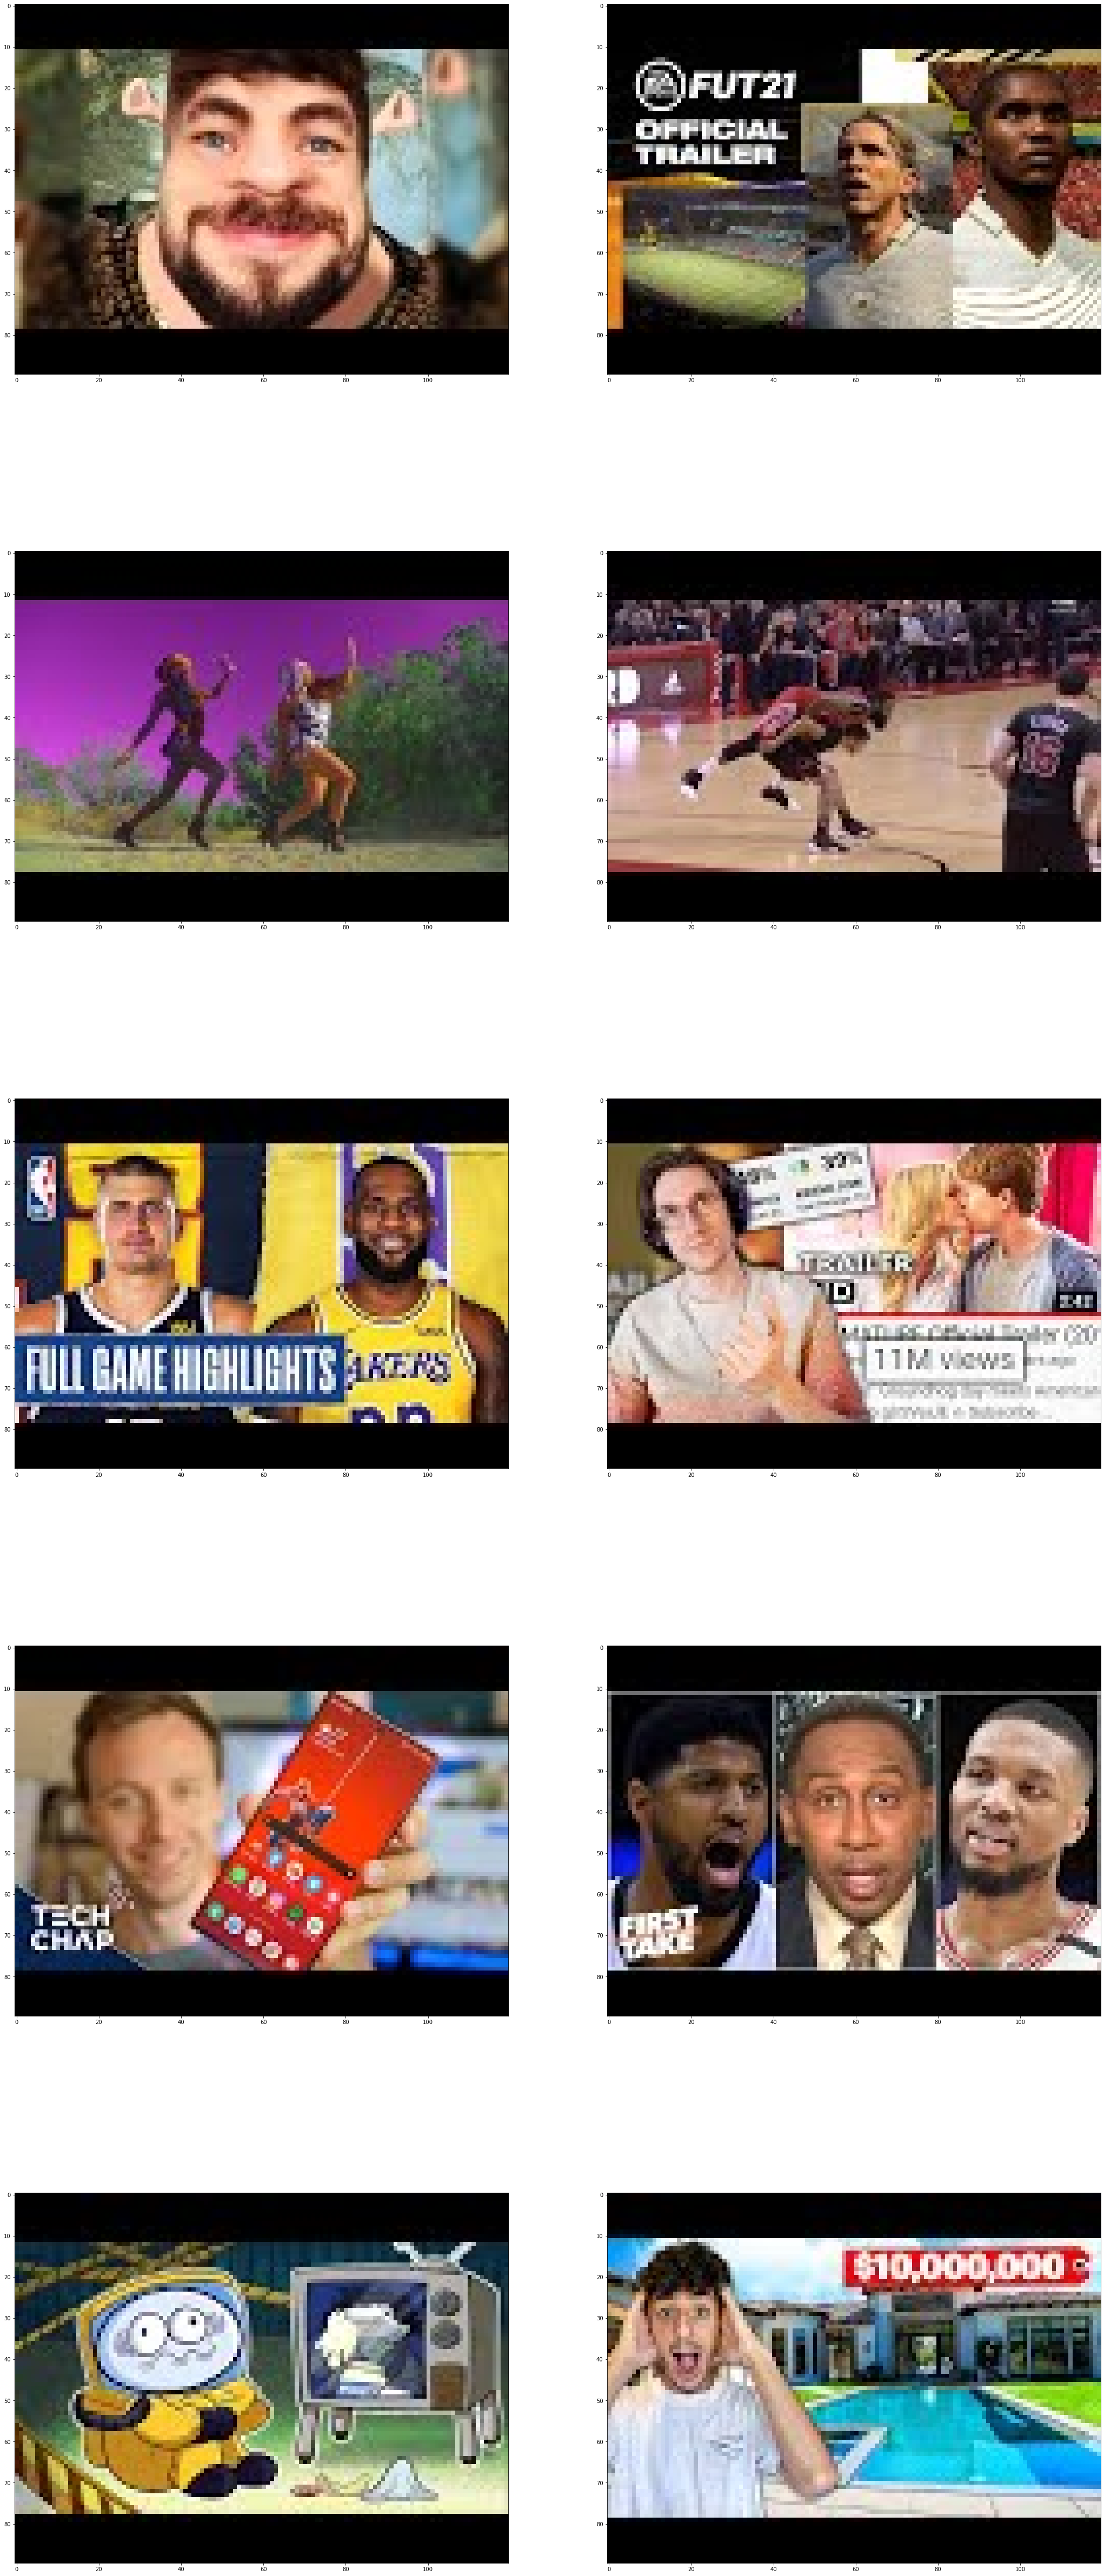

In [104]:
fig, ax=plt.subplots(5, 2, figsize=(2*18, 5*18))
for i in range(10):
    img = cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)    
    ax[i//2][i%2].imshow(img[...,::-1])
plt.show()